In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the digits dataset
digits = load_digits()

# Features and labels
X = digits.data  # Shape: (n_samples, 64)
y = digits.target  # Shape: (n_samples,)

print(f"Feature Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Feature Shape: (1797, 64)
Labels Shape: (1797,)


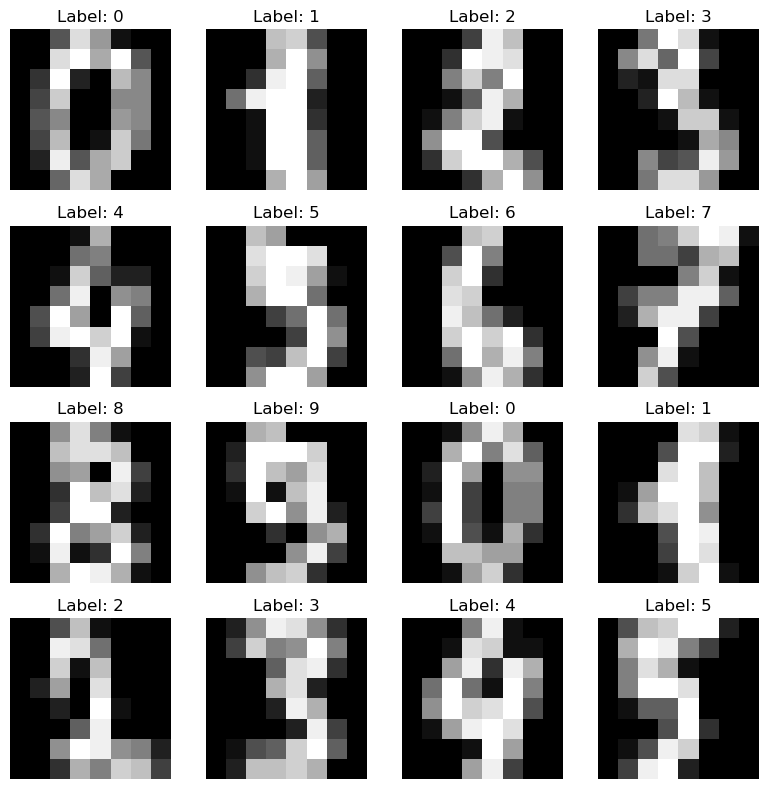

In [3]:
# Plot the first 16 digits
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(16):
    img = X[i].reshape(8, 8)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Normalize the features to [0, 1]
X /= 16.0  # Since pixel values range from 0 to 16

In [24]:
# Reshape labels to a column vector
y = y.reshape(-1, 1)

# One-Hot Encode the labels
encoder = OneHotEncoder(sparse_output=False,  categories='auto')
y_onehot = encoder.fit_transform(y.reshape(-1,1))

print(f"One-Hot Encoded Labels Shape: {y_onehot.shape}")

One-Hot Encoded Labels Shape: (1797, 10)


In [25]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Features Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Validation Features Shape: {X_val.shape}")
print(f"Validation Labels Shape: {y_val.shape}")

Training Features Shape: (1437, 64)
Training Labels Shape: (1437, 10)
Validation Features Shape: (360, 64)
Validation Labels Shape: (360, 10)


In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

In [27]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

In [28]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [29]:
def leaky_relu(x, alpha=0.01):
    return np.where(x >= 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

In [30]:
def elu(x, alpha=1.0):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    return np.where(x >= 0, 1, alpha * np.exp(x))

In [31]:
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
    return exps / np.sum(exps, axis=1, keepdims=True)

In [32]:
def softplus(x):
    return np.log(1 + np.exp(x))

def softplus_derivative(x):
    return sigmoid(x)

In [33]:
def binary_step(x):
    return np.where(x >= 0, 1, 0)

In [34]:
def piecewise_linear(x):
    return np.piecewise(x, 
                        [x < -1, (x >= -1) & (x <= 1), x > 1],
                        [lambda x: 0.5 * x + 1, 
                         lambda x: x, 
                         lambda x: 0.5 * x + 1])

In [35]:
class MLP:
    def __init__(self, layer_sizes, activation='relu', output_activation='softmax', learning_rate=0.01, epochs=1000, verbose=True):
        """
        Initializes the Multi-Layer Perceptron.

        Parameters:
        - layer_sizes: List containing the number of neurons in each layer (including input and output layers).
        - activation: Activation function for hidden layers ('sigmoid', 'tanh', 'relu', 'leaky_relu', 'elu').
        - output_activation: Activation function for the output layer ('softmax').
        - learning_rate: Learning rate for gradient descent.
        - epochs: Number of training epochs.
        - verbose: If True, prints loss every 100 epochs.
        """
        self.layer_sizes = layer_sizes
        self.activation_name = activation
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            # He initialization for ReLU and variants, Xavier for sigmoid/tanh
            if activation in ['relu', 'leaky_relu', 'elu']:
                limit = np.sqrt(2 / layer_sizes[i])
            else:
                limit = np.sqrt(1 / layer_sizes[i])
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * limit
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
        
        # Assign activation functions
        self.activation, self.activation_derivative = self._get_activation(activation)
        self.output_act, self.output_act_derivative = self._get_activation(output_activation, output=True)
        
    def _get_activation(self, name, output=False):
        if name == 'sigmoid':
            return sigmoid, sigmoid_derivative
        elif name == 'tanh':
            return tanh, tanh_derivative
        elif name == 'relu':
            return relu, relu_derivative
        elif name == 'leaky_relu':
            return lambda x: leaky_relu(x, alpha=0.01), lambda x: leaky_relu_derivative(x, alpha=0.01)
        elif name == 'elu':
            return lambda x: elu(x, alpha=1.0), lambda x: elu_derivative(x, alpha=1.0)
        elif name == 'softmax' and output:
            return softmax, None  # Derivative handled differently
        elif name == 'softplus':
            return softplus, softplus_derivative
        else:
            raise ValueError(f"Unsupported activation function: {name}")
    
    def forward(self, X):
        """
        Performs forward propagation.

        Returns a list of activations and a list of linear combinations (Z values) for each layer.
        """
        activations = [X]
        Z_values = []
        
        for i in range(len(self.weights) - 1):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            A = self.activation(Z)
            Z_values.append(Z)
            activations.append(A)
        
        # Output layer
        Z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        A = self.output_act(Z)
        Z_values.append(Z)
        activations.append(A)
        
        return activations, Z_values
    
    def compute_loss(self, Y_true, Y_pred):
        """
        Computes the cross-entropy loss.

        For numerical stability, add a small epsilon inside the log.
        """
        m = Y_true.shape[0]
        epsilon = 1e-12
        Y_pred = np.clip(Y_pred, epsilon, 1. - epsilon)
        loss = -np.sum(Y_true * np.log(Y_pred)) / m
        return loss
    
    def backward(self, activations, Z_values, Y_true):
        """
        Performs backpropagation and updates weights and biases.
        """
        m = Y_true.shape[0]
        deltas = []
        
        # Output layer error
        delta = activations[-1] - Y_true  # dL/dZ for softmax with cross-entropy
        deltas.append(delta)
        
        # Hidden layers error
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[-1], self.weights[i+1].T) * self.activation_derivative(Z_values[i])
            deltas.append(delta)
        
        deltas = deltas[::-1]  # Reverse to match the layer order
        
        # Update weights and biases
        for i in range(len(self.weights)):
            dW = np.dot(activations[i].T, deltas[i]) / m
            dB = np.sum(deltas[i], axis=0, keepdims=True) / m
            
            # Gradient Descent update
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * dB
    
    def predict(self, X):
        """
        Predicts the class labels for given input data.
        """
        activations, _ = self.forward(X)
        Y_pred = activations[-1]
        return np.argmax(Y_pred, axis=1)
    
    def fit(self, X_train, Y_train, X_val, Y_val):
        """
        Trains the MLP using the training data.

        Returns lists of training and validation accuracies.
        """
        self.train_accuracies = []
        self.val_accuracies = []
        self.losses = []
        
        for epoch in range(1, self.epochs + 1):
            # Forward pass
            activations, Z_values = self.forward(X_train)
            
            # Compute loss
            loss = self.compute_loss(Y_train, activations[-1])
            self.losses.append(loss)
            
            # Backward pass and update
            self.backward(activations, Z_values, Y_train)
            
            # Compute training accuracy
            predictions = np.argmax(activations[-1], axis=1)
            labels = np.argmax(Y_train, axis=1)
            train_acc = np.mean(predictions == labels)
            self.train_accuracies.append(train_acc)
            
            # Compute validation accuracy
            val_preds = self.predict(X_val)
            val_labels = np.argmax(Y_val, axis=1)
            val_acc = np.mean(val_preds == val_labels)
            self.val_accuracies.append(val_acc)
            
            # Verbose output
            if self.verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}/{self.epochs} - Loss: {loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")
        
        print("Training Complete!")
        return self.train_accuracies, self.val_accuracies

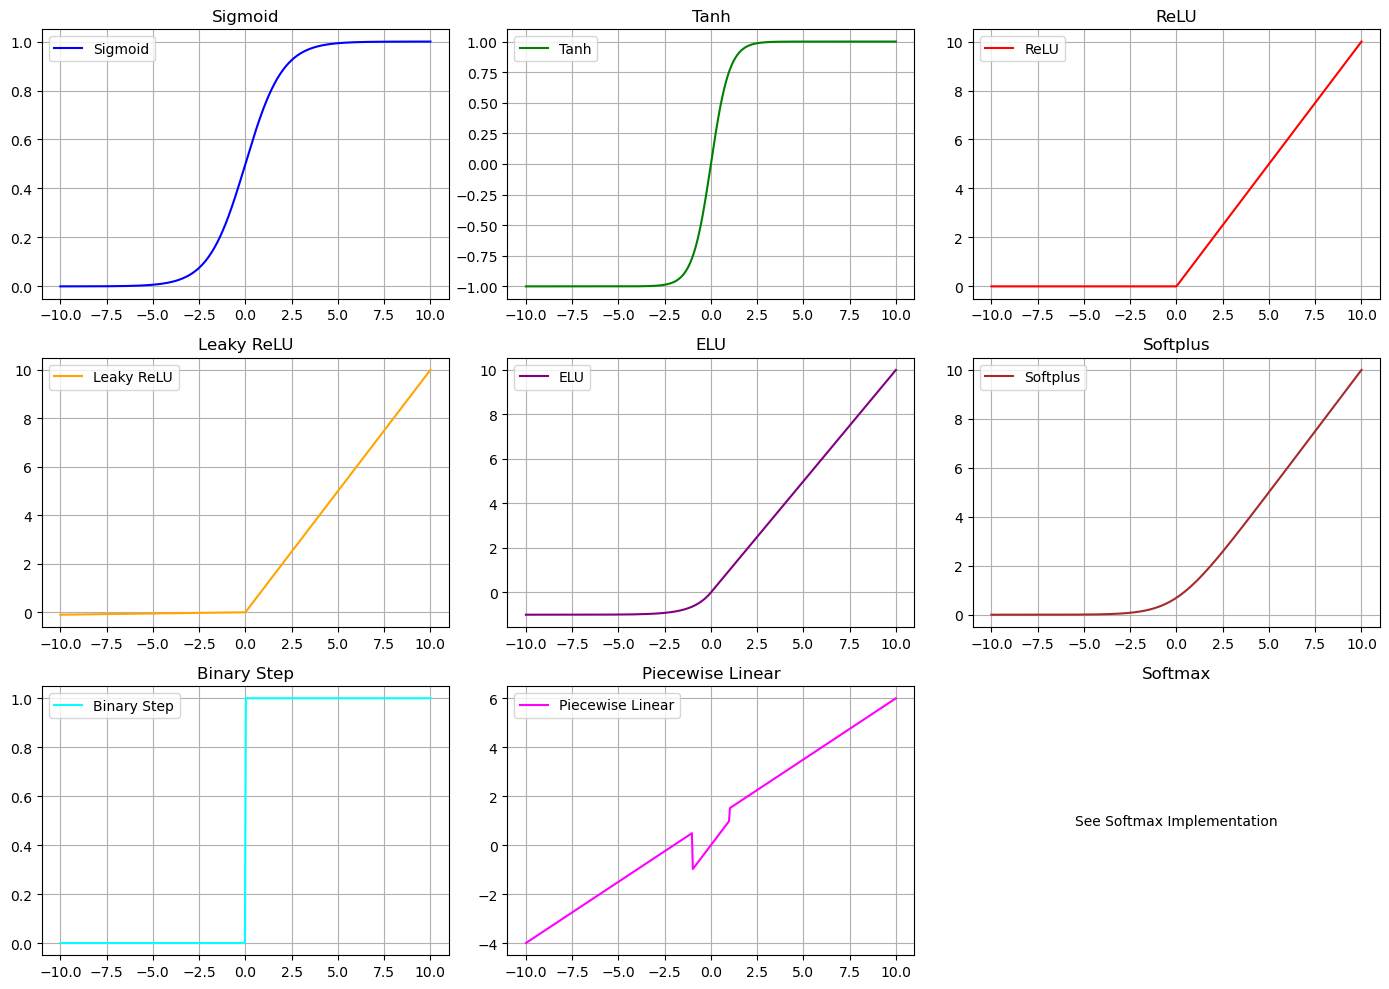

In [36]:
# Define a range of inputs
x_vals = np.linspace(-10, 10, 400)

# Compute outputs
sigmoid_vals = sigmoid(x_vals)
tanh_vals = tanh(x_vals)
relu_vals = relu(x_vals)
leaky_relu_vals = leaky_relu(x_vals)
elu_vals = elu(x_vals)
softplus_vals = softplus(x_vals)
binary_step_vals = binary_step(x_vals)
piecewise_linear_vals = piecewise_linear(x_vals)

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(3, 3, 1)
plt.plot(x_vals, sigmoid_vals, label='Sigmoid', color='blue')
plt.title('Sigmoid')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(x_vals, tanh_vals, label='Tanh', color='green')
plt.title('Tanh')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(x_vals, relu_vals, label='ReLU', color='red')
plt.title('ReLU')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 4)
plt.plot(x_vals, leaky_relu_vals, label='Leaky ReLU', color='orange')
plt.title('Leaky ReLU')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(x_vals, elu_vals, label='ELU', color='purple')
plt.title('ELU')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(x_vals, softplus_vals, label='Softplus', color='brown')
plt.title('Softplus')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 7)
plt.plot(x_vals, binary_step_vals, label='Binary Step', color='cyan')
plt.title('Binary Step')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(x_vals, piecewise_linear_vals, label='Piecewise Linear', color='magenta')
plt.title('Piecewise Linear')
plt.grid(True)
plt.legend()

# Softmax is handled differently (not plotting here)
plt.subplot(3, 3, 9)
plt.axis('off')
plt.title('Softmax')
plt.text(0.5, 0.5, 'See Softmax Implementation', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

In [37]:
# Define layer sizes
input_size = 64
hidden1_size = 128
hidden2_size = 64
output_size = 10  # Digits 0-9

layer_sizes = [input_size, hidden1_size, hidden2_size, output_size]

In [43]:
# Initialize the MLP
mlp = MLP(
    layer_sizes=layer_sizes,
    activation='relu',
    output_activation='softmax',
    learning_rate=0.01,
    epochs=15_000,
    verbose=True  # Set to True to see progress
)

In [44]:
# Train the MLP
train_acc, val_acc = mlp.fit(X_train, y_train, X_val, y_val)

Epoch 100/100000 - Loss: 1.8545 - Train Acc: 0.5505 - Val Acc: 0.5500
Epoch 200/100000 - Loss: 1.3992 - Train Acc: 0.7550 - Val Acc: 0.7111
Epoch 300/100000 - Loss: 1.0303 - Train Acc: 0.8490 - Val Acc: 0.8417
Epoch 400/100000 - Loss: 0.7651 - Train Acc: 0.8928 - Val Acc: 0.8778
Epoch 500/100000 - Loss: 0.5875 - Train Acc: 0.9137 - Val Acc: 0.9056
Epoch 600/100000 - Loss: 0.4709 - Train Acc: 0.9276 - Val Acc: 0.9250
Epoch 700/100000 - Loss: 0.3922 - Train Acc: 0.9374 - Val Acc: 0.9361
Epoch 800/100000 - Loss: 0.3365 - Train Acc: 0.9422 - Val Acc: 0.9389
Epoch 900/100000 - Loss: 0.2951 - Train Acc: 0.9471 - Val Acc: 0.9444
Epoch 1000/100000 - Loss: 0.2632 - Train Acc: 0.9513 - Val Acc: 0.9500
Epoch 1100/100000 - Loss: 0.2381 - Train Acc: 0.9569 - Val Acc: 0.9528
Epoch 1200/100000 - Loss: 0.2181 - Train Acc: 0.9589 - Val Acc: 0.9528
Epoch 1300/100000 - Loss: 0.2016 - Train Acc: 0.9638 - Val Acc: 0.9556
Epoch 1400/100000 - Loss: 0.1877 - Train Acc: 0.9666 - Val Acc: 0.9556
Epoch 1500/1000

KeyboardInterrupt: 

In [40]:
# Predict on validation set
y_val_pred = mlp.predict(X_val)

# Convert one-hot encoded labels back to integer labels
y_val_true = np.argmax(y_val, axis=1)

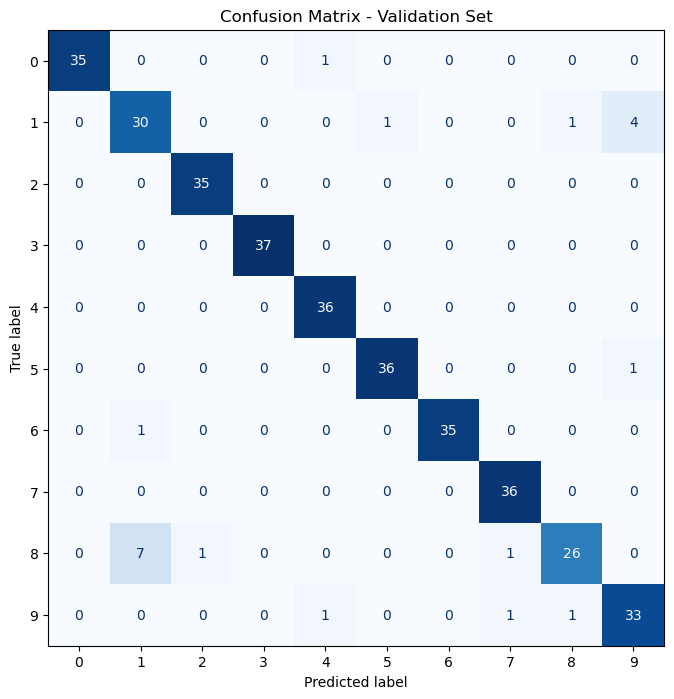

In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title('Confusion Matrix - Validation Set')
plt.show()

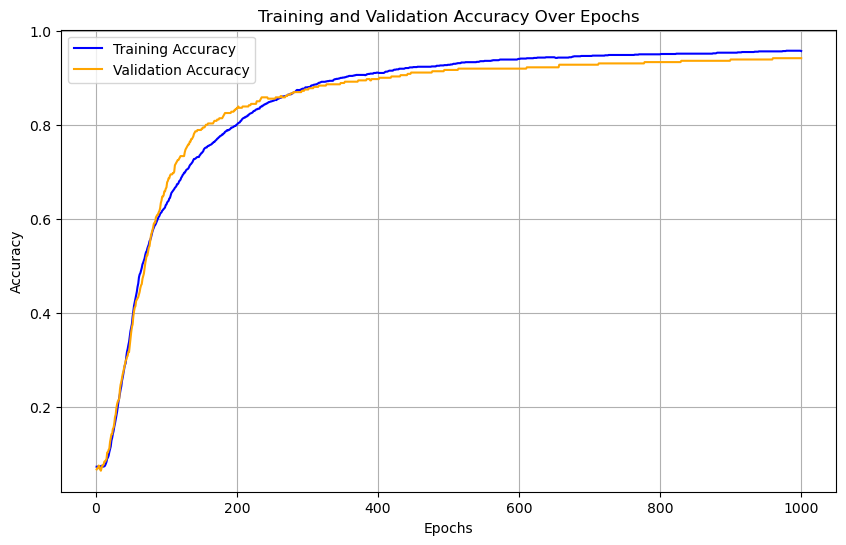

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, mlp.epochs + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, mlp.epochs + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()